In [8]:
# Cell 1: Imports & project-root setup
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

def find_project_root(marker_dir: str = "artifacts") -> Path:
    start = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    return Path.cwd().resolve()

PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

from common.config import DEVICE
from models.autoencoder.dataset_autoencoder import DatasetAutoencoder
from models.autoencoder.utils import split_dataset
from models.autoencoder.architectures.flexible_autoencoder import ConvAutoencoder

In [9]:
# Cell 2: Key constants (EDIT THESE AS NEEDED)
DATA_PATH       = Path("data/waveforms")
REDUCTION, N    = "resample", 150
TRAIN_FRAC      = 0.8
SEED            = 42
BATCH_SIZE      = 50
LATENT_DIM      = 16
DROPOUT         = 0.2
USE_BATCHNORM   = True
LR              = 1e-3

CKPT_DIR        = PROJECT_ROOT / "artifacts" / "autoencoder" / "checkpoints"
CKPT_FILENAME   = "ConvAENormEnd_resample150_lat16_do20_bn_2025-08-21_05-46-30.pt"
CKPT_PATH       = CKPT_DIR / CKPT_FILENAME

PLOTS_DIR       = PROJECT_ROOT / "results" / "autoencoder" / "Norm End, Resample150, Lat16, DO 20, BN, Adam, MSE, 100e, 2025-08-21_05-46-30"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [10]:
# Cell 3: Load the model

# load dataset and make dataloader for validation data
dataset = DatasetAutoencoder(
    path=Path("data/waveforms"),
    reduction=REDUCTION,
    n=N,
    save=False,        # won’t try to write a new cache
    force_reload=False # will load the cache if present
)

_, val_set = split_dataset(dataset, train_frac=TRAIN_FRAC, seed=SEED)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

# load model
loaded_model = ConvAutoencoder.load(
    path = CKPT_PATH,
    dataset = dataset,
    device=DEVICE
).to(DEVICE)

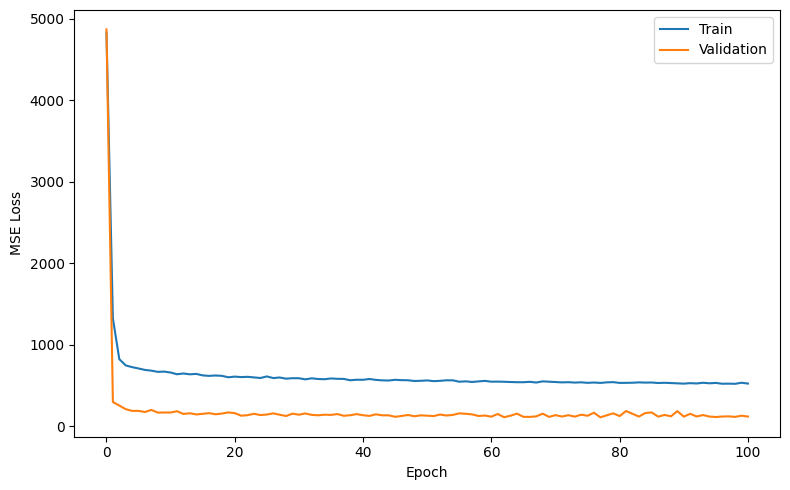

In [11]:
# Cell 4: Plot training & validation loss curves
train_ls = loaded_model.history["train_loss"]
val_ls = loaded_model.history["val_loss"]

plt.figure(figsize=(8,5))
plt.plot(train_ls, label="Train")
plt.plot(val_ls,   label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "loss_curves.png")
plt.show()

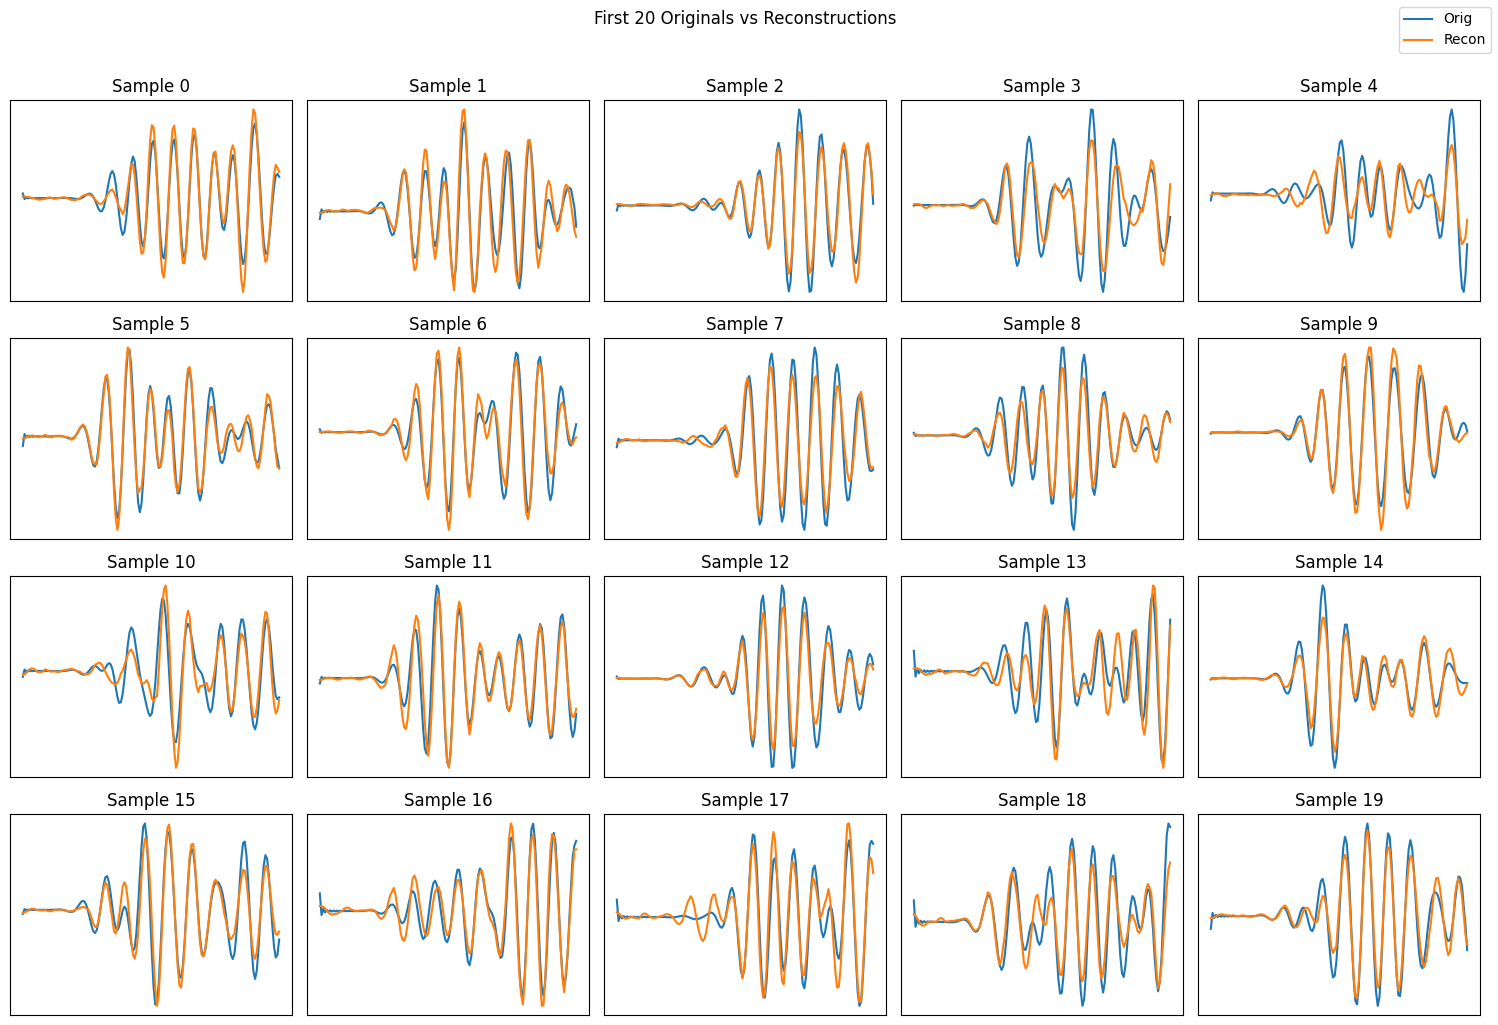

In [12]:
# Cell 5: Plot first 20 originals vs reconstructions

# grab one batch (and only keep the first 20 samples)
batch = next(iter(val_loader))[:20].to(DEVICE)   # shape: [20, length]

# run it through the autoencoder
with torch.no_grad():
    recon = loaded_model(batch)                  # shape: [20, length]

# move to CPU / numpy
orig_np  = batch.cpu().numpy()
recon_np = recon.cpu().numpy()

# plot a 4×5 grid
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    ax.plot(orig_np[i].squeeze(), label='Orig')
    ax.plot(recon_np[i].squeeze(), label='Recon')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"Sample {i}")

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.suptitle("First 20 Originals vs Reconstructions", y=1.02)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "first20_recons.png")
plt.show()

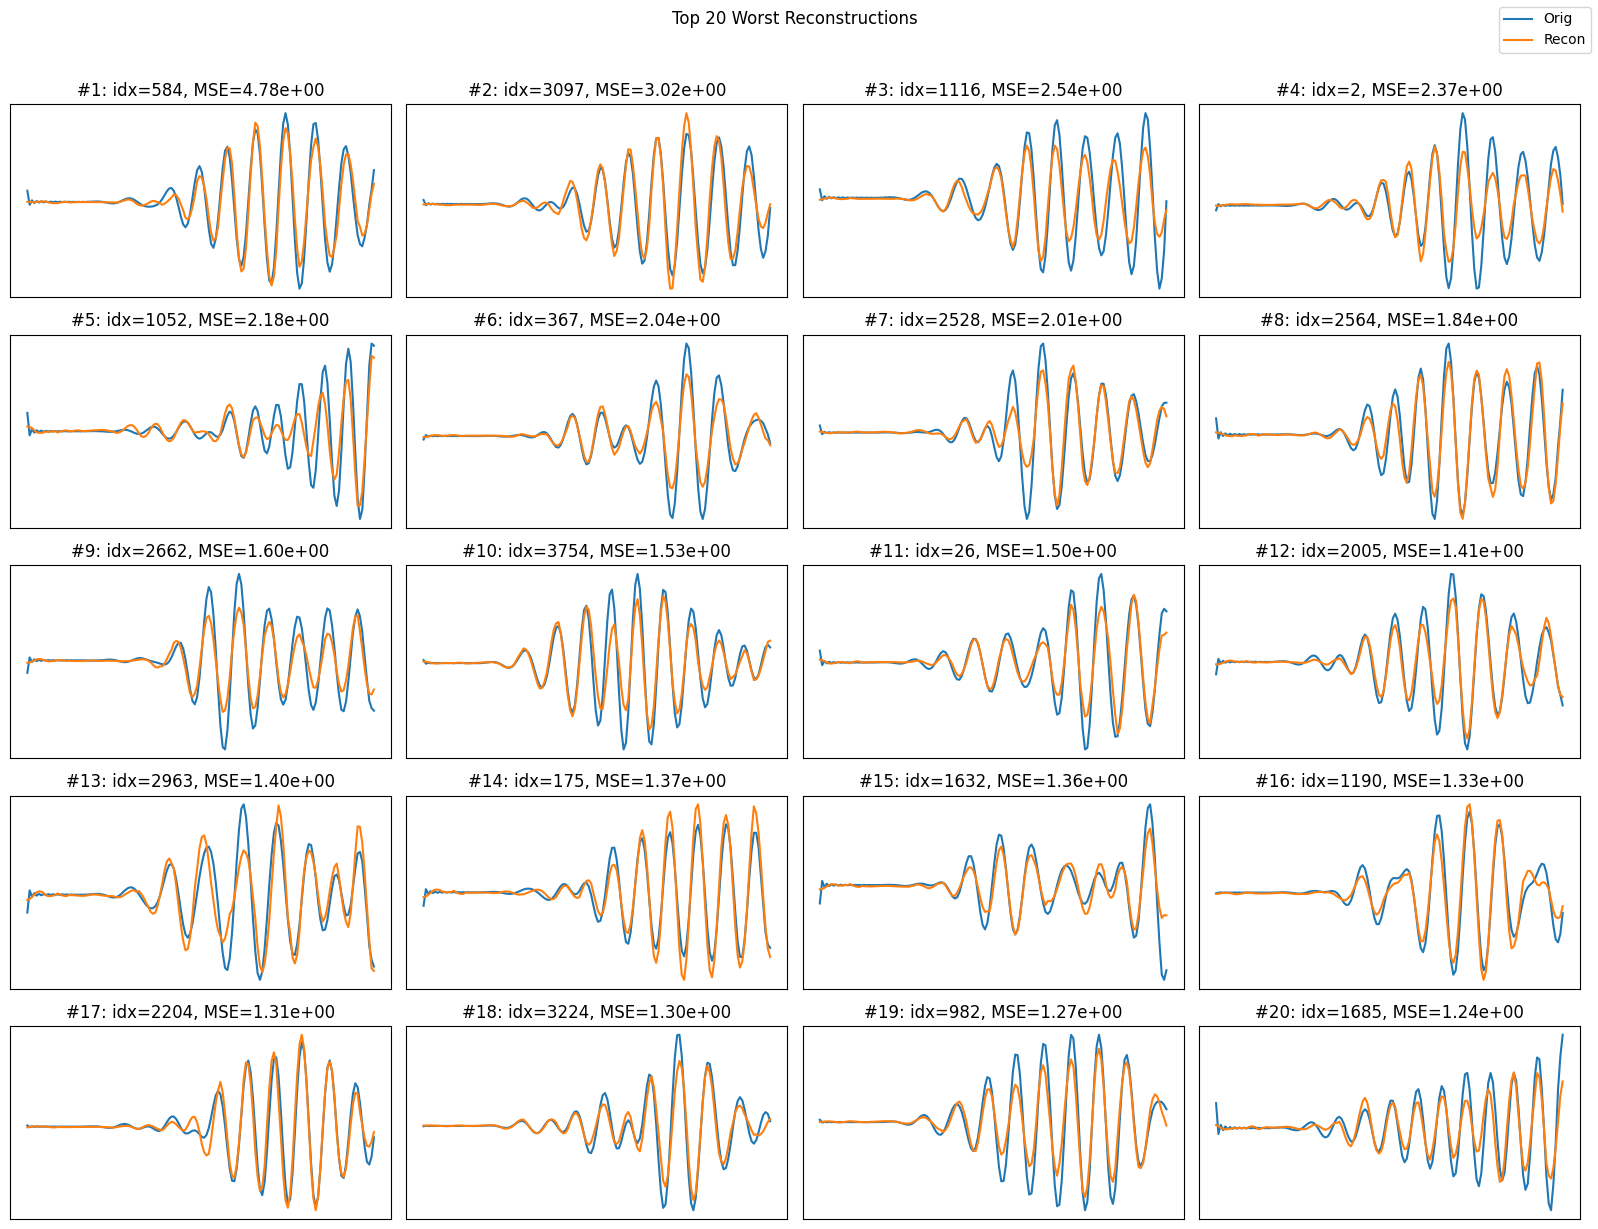

In [13]:
# Cell 6: Compute full-val MSEs and plot top-20 worst reconstructions

# Run the entire validation set through the model
mse_list, waves_list, recons_list = [], [], []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(DEVICE)                 # [B, L]
        recon = loaded_model(batch).cpu().numpy()# [B, L]
        orig  = batch.cpu().numpy()              # [B, L]

        waves_list.append(orig)
        recons_list.append(recon)
        # per-sample MSE along the length dimension
        mse_list.append(((recon - orig) ** 2).mean(axis=1))

# 2) Concatenate across all batches
waves_all = np.concatenate(waves_list, axis=0)   # [N, L]
recons_all = np.concatenate(recons_list, axis=0) # [N, L]
mse_all    = np.concatenate(mse_list,    axis=0) # [N]

# 3) Identify the top-20 worst examples
top20_idx = np.argsort(mse_all)[-20:][::-1]

# 4) Plot them in a 5×4 grid
fig, axes = plt.subplots(5, 4, figsize=(16,12))
for i, idx in enumerate(top20_idx):
    ax = axes.flatten()[i]
    ax.plot(waves_all[idx].squeeze(), label='Orig')
    ax.plot(recons_all[idx].squeeze(),  label='Recon')
    ax.set_title(f"#{i+1}: idx={idx}, MSE={mse_all[idx]:.2e}")
    ax.set_xticks([]); ax.set_yticks([])

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Top 20 Worst Reconstructions", y=1.02)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "top20_worst_recons.png")
plt.show()


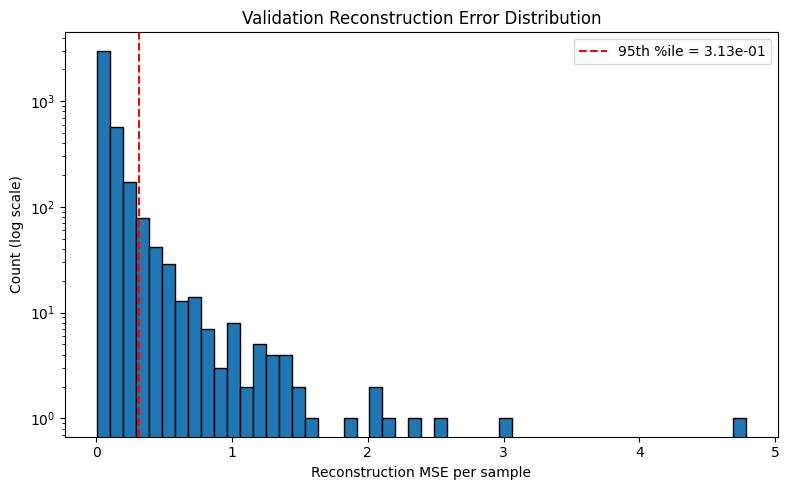

In [14]:
# Cell 5: Histogram of validation-set MSE distribution
plt.figure(figsize=(8,5))
plt.hist(mse_all, bins=50, edgecolor='black', log=True)
plt.xlabel('Reconstruction MSE per sample')
plt.ylabel('Count (log scale)')
plt.title('Validation Reconstruction Error Distribution')
thresh = np.percentile(mse_all, 95)
plt.axvline(thresh, color='red', linestyle='--', label=f'95th %ile = {thresh:.2e}')
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "mse_histogram.png")
plt.show()
